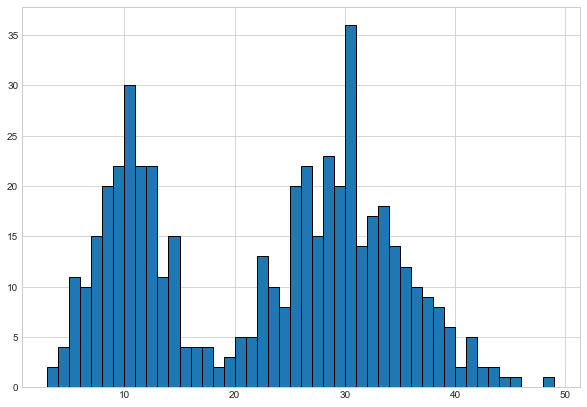

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

def to_one_hot(s, n_clusters):
    return np.eye(n_clusters)[s]


# Generate samples
n_clusters = 2
each_cluster_samples = [200, 300]
n_samples = np.sum(each_cluster_samples)
pi_true = each_cluster_samples / n_samples

s_true = to_one_hot(np.concatenate([np.repeat(i, n) for i, n in enumerate(each_cluster_samples)]),
                    n_clusters)

lam_true = np.array([10, 30], np.float32)
x = np.stack([stats.poisson.rvs(lam_k, size=n_samples)
              for lam_k in lam_true], axis=1)
x = np.sum(x * s_true, axis=1)

fig, axes = plt.subplots(1, 1, figsize = (10, 7))
axes.hist(x, bins=int(np.max(x) - np.min(x)), ec = "black")
plt.show()

In [2]:
def log_sum_exp(X):
    max_x = np.max(X, axis = 1).reshape(-1, 1)
    return np.log(np.sum(np.exp(X - max_x), axis = 1).reshape(-1, 1)) + max_x

def Poisson_Mixture_Gibbs_Sampling(data, K, n_iter):

    # パラメータの初期値の設定
    Pi = np.array([0.5, 0.5])
    Lam = np.array([1, 1])
    N = len(data)
    X = data.reshape(-1, 1) # X.shape = (500, 1)
    a = 1
    b = 1
    a_hat_list = []
    b_hat_list = []
    alpha = 1  

    for _ in range(n_iter):
        # 潜在変数Sをサンプリングする
        S = np.zeros([N, K])  # 潜在変数Sの初期化
        tmp = np.dot(X, np.log(Lam).reshape(1, -1)) - Lam.reshape(1, -1) + np.log(Pi).reshape(1, -1)
        eta = np.exp(tmp - log_sum_exp(tmp))
        for n in range(N):
            S[n, :] = stats.multinomial.rvs(n = 1, p = eta[n, :], size = 1)
        
        
        a_hat_k = np.concatenate(np.dot(X.T, S)) + a # np.concatenateで[[**, **]] --> [**, **]にする
        #a_hat = a_hat_k.copy()
        #a_hat_list.append(a_hat)

        b_hat = np.sum(S, axis = 0) + b
        b_hat_list.append(b_hat)

        #λのサンプリング
        for k in range(K):
            Lam[k] = stats.gamma.rvs(a = a_hat_k[k], scale = 1/b_hat[k], size = 1)

     
        # ディリクレ分布のパラメータ
        alpha_hat = np.sum(S, axis = 0) + alpha
        # πのサンプリング
        Pi = stats.dirichlet.rvs(alpha = alpha_hat)


    return S, eta

In [3]:
S, eta = Poisson_Mixture_Gibbs_Sampling(data = x, K = 2, n_iter = 200)

/Users/hayashidaichi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


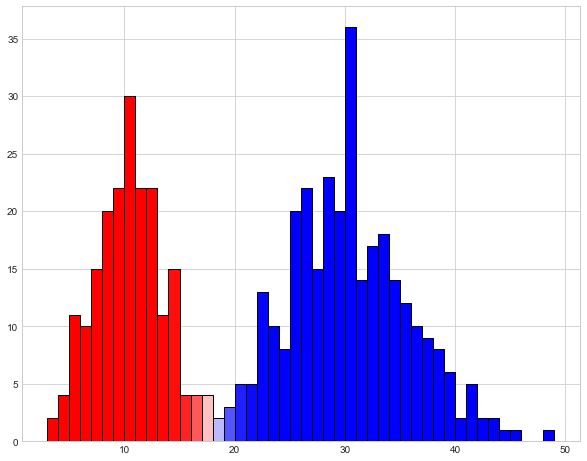

In [9]:
# Plot
x_max = x.max()
x_min = x.min()
bins = np.linspace(x_min, x_max, x_max - x_min + 1)
x_dig = np.digitize(x, bins)

weight = np.zeros(len(bins))
count = np.zeros(len(bins))
for x_dig_i, eta_0_i in zip(x_dig, eta[:, 0]):   # 組み合わせをzipで取ってくる
    weight[x_dig_i - 1] += eta_0_i
    count[x_dig_i - 1] += 1

weight = [w / c if c != 0 else 0 for w, c in zip(weight, count)]

fig, axes = plt.subplots(1, 1, figsize = (10, 8))
_, _, patches = axes.hist(x, bins=bins, ec = "black")
cm = plt.cm.get_cmap('bwr')
colors = [cm(w) for w in weight]
for patch, color in zip(patches, colors):
    patch.set_fc(color)
    
plt.show()